In [1]:
import xdem
import rioxarray as rix
import xarray as xr
import numpy as np
import glob
import os
from datetime import datetime
import matplotlib.pyplot as plt
import altair as alt
from pathlib import Path
from rasterio.enums import Resampling
import pandas as pd
import geopandas as gpd
import geoutils as gu
from pysheds.grid import Grid

import matplotlib.cm
import copy
import seaborn as sns


In [4]:
dtm_fn = '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mt_rainier_comparison/rainier_3dep_dtm.tif'

# Prepare terrain attributes

In [6]:
dtm = xdem.DEM(dtm_fn)

In [7]:
slope = xdem.terrain.slope(dtm)
aspect = xdem.terrain.aspect(dtm)
curvature = xdem.terrain.curvature(dtm)

/home/elilouis/miniconda3/envs/hsfm-test/lib/python3.8/site-packages/xdem/terrain.py:376: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (


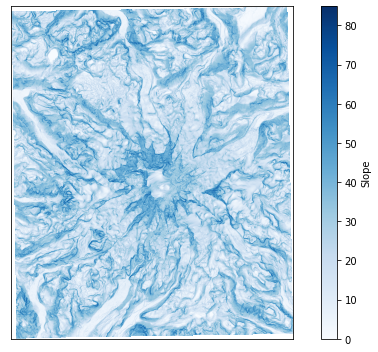

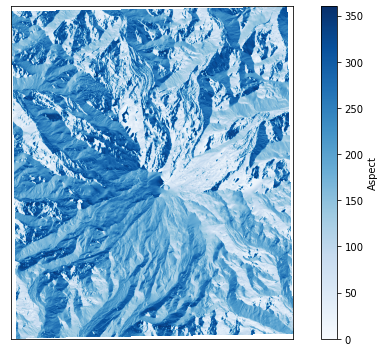

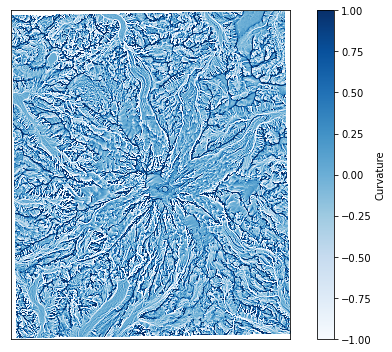

In [8]:
def plot_attribute(attribute, cmap = 'Blues', label=None, vlim=None):

    add_cb = True if label is not None else False

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)

    if vlim is not None:
        if isinstance(vlim, (int, float)):
            vlims = {"vmin": -vlim, "vmax": vlim}
        elif len(vlim) == 2:
            vlims = {"vmin": vlim[0], "vmax": vlim[1]}
    else:
        vlims = {}

    attribute.show(
        ax=ax,
        cmap=cmap,
        add_cb=add_cb,
        cb_title=label,
        **vlims
    )

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

    plt.show()
plot_attribute(slope, label='slope'.title())
plot_attribute(aspect, label='aspect'.title())
plot_attribute(curvature, label='curvature'.title(), vlim=1)

## Use pysheds for drainage area

In [9]:
grid_pysheds = Grid.from_raster(dtm_fn)
dem_pysheds = grid_pysheds.read_raster(dtm_fn)

pit_filled_dem_pysheds = grid_pysheds.fill_pits(dem_pysheds)
flooded_dem_pysheds = grid_pysheds.fill_depressions(pit_filled_dem_pysheds)
inflated_dem_pysheds = grid_pysheds.resolve_flats(flooded_dem_pysheds)
fdir_pysheds = grid_pysheds.flowdir(inflated_dem_pysheds) #May need to pass in a dirmap dirmap=dirmap
acc_pysheds = grid_pysheds.accumulation(fdir_pysheds)

In [10]:
import tempfile
with tempfile.NamedTemporaryFile() as tmp:
    Grid.from_raster(acc_pysheds).to_raster(acc_pysheds, tmp.name)
    darea = rix.open_rasterio(tmp.name)

In [11]:
darea = darea*np.abs(dtm.res[0]*dtm.res[1])

In [12]:
dtm = rix.open_rasterio(dtm_fn, masked=True)

# Create dataset

In [14]:
dataset = xr.Dataset({
    'dtm': dtm,
    'drainage area': darea,
    'slope': slope.to_xarray(),
    'aspect': aspect.to_xarray(),
    'curvature': curvature.to_xarray()
})

/home/elilouis/miniconda3/envs/hsfm-test/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/elilouis/miniconda3/envs/hsfm-test/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/elilouis/miniconda3/envs/hsfm-test/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

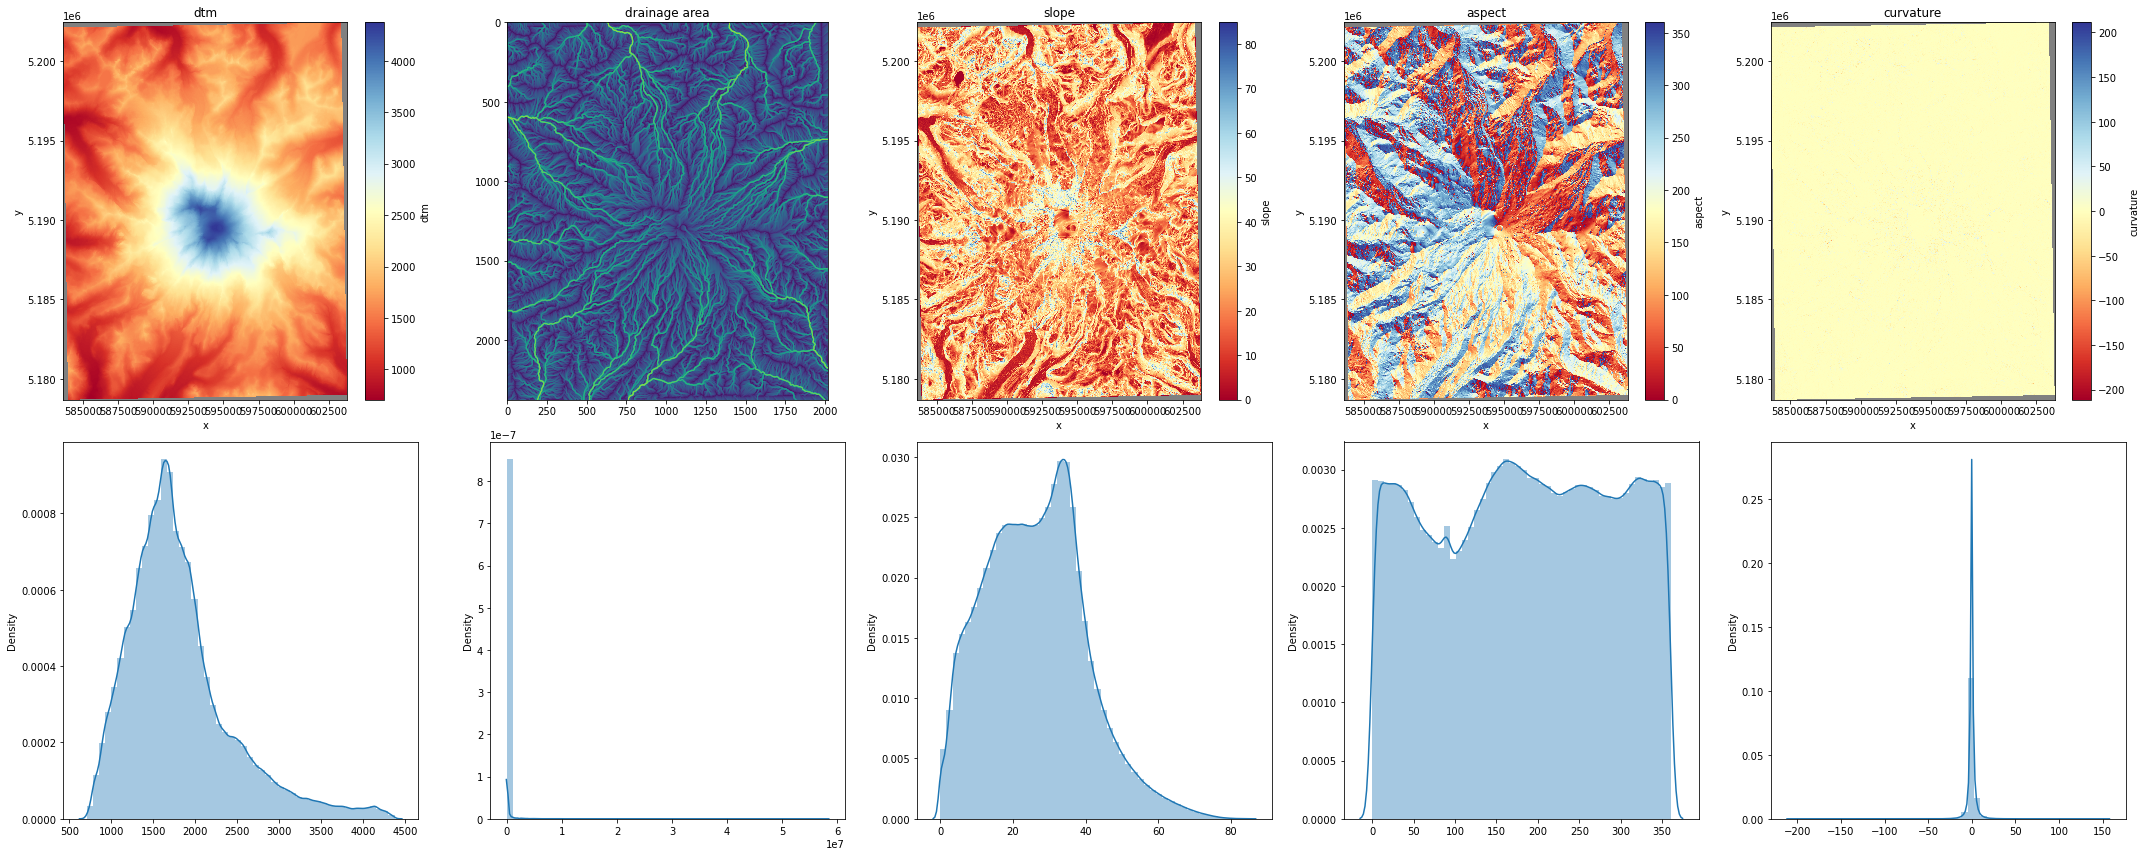

In [15]:
fig, axes = plt.subplots(2, len(dataset.data_vars), figsize=(6*len(dataset.data_vars), 6*2))

cmap = copy.copy(matplotlib.cm.RdYlBu)
_ = cmap.set_bad('grey')
from matplotlib import colors

for i in range(0, len(dataset.data_vars)):
    if list(dataset.data_vars)[i] == 'drainage area':
        axes[0, i].imshow(dataset['drainage area'].values.squeeze(), norm=colors.LogNorm())
    else:
        dataset[list(
            dataset.data_vars)[i]
        ].plot(ax = axes[0, i], cmap=cmap)
    axes[0, i].set_title(list(dataset.data_vars)[i])
    sns.distplot(dataset[list(dataset.data_vars)[i]].values, ax = axes[1, i])
    # histplot instead of distplot
    # and add the keyword args  kde=True, stat="density", linewidth=0
    # sns.histplot(dataset[list(dataset.data_vars)[i]].values.squeeze(), ax = axes[1, i], kde=True, stat="density", linewidth=0)

plt.tight_layout()
plt.show()

# Merge Anderson's erosion polygons

In [75]:
emmons_files = glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mt_rainier_comparison/Rainier_topographic_change_AOIs/Emmons*.shp")
emmons_files = [f for f in emmons_files if "rockfall" not in f]

nisqually_files = glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mt_rainier_comparison/Rainier_topographic_change_AOIs/Nisqually*.shp")

winthrop_files = glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mt_rainier_comparison/Rainier_topographic_change_AOIs/winthrop*.shp")

southtahoma_files = glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mt_rainier_comparison/Rainier_topographic_change_AOIs/SouthTahoma*.shp")

In [76]:
emmons_gdf = pd.concat([gpd.read_file(f) for f in emmons_files])
emmons_gdf['Valley Name'] = 'Emmons'

nisqually_gdf = pd.concat([gpd.read_file(f) for f in nisqually_files])
nisqually_gdf['Valley Name'] = 'Nisqually'

winthrop_gdf = pd.concat([gpd.read_file(f) for f in winthrop_files])
winthrop_gdf['Valley Name'] = 'Winthrop'

southtahoma_gdf = pd.concat([gpd.read_file(f) for f in southtahoma_files])
southtahoma_gdf['Valley Name'] = 'South Tahoma'

erosion_gdf = pd.concat([
    emmons_gdf,
    nisqually_gdf,
    winthrop_gdf,
    southtahoma_gdf
])

In [77]:
erosion_gdf = erosion_gdf.dissolve(by="Valley Name")
erosion_gdf['area'] = erosion_gdf.geometry.area
erosion_gdf = erosion_gdf.reset_index()

In [78]:
erosion_gdf

,Valley Name,geometry,Id,area
0,Emmons,"MULTIPOLYGON (((600214.479 5193039.818, 600162...",0,9.931577e+05
1,Nisqually,"MULTIPOLYGON (((595639.110 5182531.240, 595630...",0,7.347605e+05
2,South Tahoma,"MULTIPOLYGON (((585653.963 5180822.253, 585663...",0,1.574818e+06
3,Winthrop,"MULTIPOLYGON (((595696.251 5182655.467, 595697...",0,6.236146e+05


<AxesSubplot:>

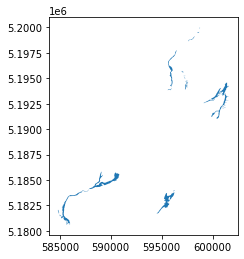

In [79]:
erosion_gdf.plot()

# Calculate terrain characteristics for each valley

In [81]:
erosion_mean_results = erosion_gdf.apply(
    (lambda row: dataset.rio.clip([row['geometry']]).to_dataframe().agg({
            'dtm': 'mean',
            'drainage area': 'max',
            'slope': 'mean',
            'aspect': 'mean',
            'curvature': 'mean',
        }
    )),
    axis='columns', result_type='expand'
)
erosion_gdf[erosion_mean_results.columns] = erosion_mean_results

In [82]:
erosion_gdf

,Valley Name,geometry,Id,area,dtm,drainage area,slope,aspect,curvature
0,Emmons,"MULTIPOLYGON (((600214.479 5193039.818, 600162...",0,9.931577e+05,1647.750977,17605500.0,20.110899,157.324325,-0.336028
1,Nisqually,"MULTIPOLYGON (((595639.110 5182531.240, 595630...",0,7.347605e+05,1450.885742,16048100.0,28.171115,219.611364,-0.533208
2,South Tahoma,"MULTIPOLYGON (((585653.963 5180822.253, 585663...",0,1.574818e+06,1334.362549,25703900.0,19.761250,219.954424,-0.310287
3,Winthrop,"MULTIPOLYGON (((595696.251 5182655.467, 595697...",0,6.236146e+05,1659.153931,33116200.0,22.736744,193.831265,-0.747441


# Load watershed polygons and compare area with drainage area from DTM

In [83]:
emmons_watershed = gpd.read_file("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mt_rainier_comparison/emmons_watershed.geojson")
nisqually_watershed = gpd.read_file("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mt_rainier_comparison/nisqually_watershed.geojson")
south_tahoma_watershed = gpd.read_file("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mt_rainier_comparison/south_tahoma_watershed.geojson")
winthrop_watershed = gpd.read_file("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mt_rainier_comparison/winthrop_watershed.geojson")

emmons_watershed['Valley Name'] = "Emmons"
nisqually_watershed['Valley Name'] = "Nisqually"
south_tahoma_watershed['Valley Name'] = "South Tahoma"
winthrop_watershed['Valley Name'] = "Winthrop"

watershed_gdf = pd.concat([
    emmons_watershed,
    nisqually_watershed,
    south_tahoma_watershed,
    winthrop_watershed
])
watershed_gdf = watershed_gdf.to_crs(erosion_gdf.crs)
watershed_gdf['area'] = watershed_gdf.geometry.area

<AxesSubplot:>

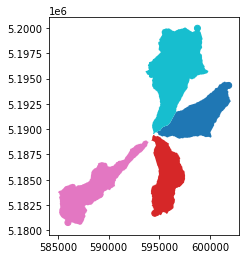

In [84]:
watershed_gdf.plot(column='Valley Name')

In [85]:
watershed_gdf['area'] = watershed_gdf['area']/1e6
erosion_gdf['drainage area'] = erosion_gdf['drainage area']/1e6

In [86]:
watershed_gdf

,id,geometry,Valley Name,area
0,globalwatershedpoint,POINT (601835.843 5194318.899),Emmons,0.000000
1,globalwatershed,"POLYGON ((600090.396 5189167.635, 600033.103 5...",Emmons,18.809338
0,globalwatershedpoint,POINT (594539.689 5181693.540),Nisqually,0.000000
1,globalwatershed,"POLYGON ((595805.868 5181677.412, 595691.252 5...",Nisqually,16.309418
0,globalwatershedpoint,POINT (585962.176 5180778.162),South Tahoma,0.000000
1,globalwatershed,"POLYGON ((587307.703 5180596.970, 587135.766 5...",South Tahoma,20.872607
0,globalwatershedpoint,POINT (598750.629 5199965.003),Winthrop,0.000000
1,globalwatershed,"POLYGON ((594498.899 5189545.849, 594412.959 5...",Winthrop,33.775544


In [87]:
erosion_gdf

,Valley Name,geometry,Id,area,dtm,drainage area,slope,aspect,curvature
0,Emmons,"MULTIPOLYGON (((600214.479 5193039.818, 600162...",0,9.931577e+05,1647.750977,17.6055,20.110899,157.324325,-0.336028
1,Nisqually,"MULTIPOLYGON (((595639.110 5182531.240, 595630...",0,7.347605e+05,1450.885742,16.0481,28.171115,219.611364,-0.533208
2,South Tahoma,"MULTIPOLYGON (((585653.963 5180822.253, 585663...",0,1.574818e+06,1334.362549,25.7039,19.761250,219.954424,-0.310287
3,Winthrop,"MULTIPOLYGON (((595696.251 5182655.467, 595697...",0,6.236146e+05,1659.153931,33.1162,22.736744,193.831265,-0.747441


# Manually input cumulative net change

In [89]:
list(erosion_gdf['Valley Name'])

['Emmons', 'Nisqually', 'South Tahoma', 'Winthrop']

In [108]:
volume_df = pd.DataFrame({
    "Valley Name": ['Emmons', 'Nisqually', 'South Tahoma', 'Winthrop'],
    "cumulative volume": [436000, 1018200, 7939000, 2302000],
    "N years": [56,56,57,56]
})

In [109]:
df = volume_df.merge(erosion_gdf, on ='Valley Name')

# Sediment yield calculations!


In [110]:
df['watershed area (square km)'] = df['drainage area']

In [111]:
porosity = 0.35
density = 2600 # kg / m^3
kg_per_metric_ton = 1000

In [112]:
df['cumulative mass'] = df['cumulative volume'] * (1 - porosity) * density
df['sediment yield (kg / yr)'] =  df['cumulative mass'] / df['N years']
df['sediment yield (t / yr)'] =  df['cumulative mass'] / df['N years'] / kg_per_metric_ton
df['sediment yield normalized (kg / km^2 / yr)'] =  df['cumulative mass'] / df['watershed area (square km)'] / df['N years']
df['sediment yield normalized (t / km^2 / yr)'] = df['sediment yield normalized (kg / km^2 / yr)'] / kg_per_metric_ton

In [113]:
alt.Chart(df.drop(columns='geometry')).mark_bar().encode( 
    alt.X('Valley Name', sort='-y'),
    alt.Y("sediment yield (t / yr)"),
) | alt.Chart(df.drop(columns='geometry')).mark_bar().encode(
    alt.X('Valley Name', sort='-y'),
    alt.Y("sediment yield normalized (t / km^2 / yr)"),
)

alt.HConcatChart(...)

In [115]:
df['drainage area (km)'] = df['watershed area (square km)']

In [117]:
src = df.drop(columns='geometry')
(
    alt.Chart(src).mark_circle(size=75).encode(
        alt.X("drainage area (km):Q"),
        alt.Y("sediment yield (t / yr):Q"),
        alt.Color('Valley Name:N')
    ).properties(width=200, height = 200) | alt.Chart(src).mark_circle(size=75).encode(
        alt.X("slope:Q"),
        alt.Y("sediment yield (t / yr):Q"),
        alt.Color('Valley Name:N')
    ).properties(width=200, height = 200)
) & (
    alt.Chart(src).mark_circle(size=75).encode(
        alt.X("drainage area (km):Q"),
        alt.Y("sediment yield normalized (t / km^2 / yr):Q"),
        alt.Color('Valley Name:N')
    ).properties(width=200, height = 200) | alt.Chart(src).mark_circle(size=75).encode(
        alt.X("slope:Q"),
        alt.Y("sediment yield normalized (t / km^2 / yr):Q"),
        alt.Color('Valley Name:N')
    ).properties(width=200, height = 200)
)

alt.VConcatChart(...)

In [119]:
ls outputs/ | grep csv

glacier_area.csv
slopes.csv
terrain_attributes.csv
terrain_attributes_erosionarea_bytype.csv
terrain_attributes_erosionarea.csv
terrain_attributes_processpolygons.csv
terrain_attributes_processpolygons_maxdrainage.csv
terrain_attributes_watershedarea.csv
uncertainty.csv


In [120]:
src.to_csv("outputs/sediment_yield_data_rainier.csv")